## Preprocessing 

Darren Pandiangan - 0706012310027 <br>
Delvincent Patricio - 0706012310026 <br>
Lie, Samuel M K  - 0706012210011 <br><br>
Dataset link (Download Accepted csv only): https://www.kaggle.com/datasets/wordsforthewise/lending-club/data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
sns.set(style="whitegrid")

df = pd.read_csv("data/accepted_2007_to_2018Q4.csv", low_memory=False) #low_memory=False untuk menghindari peringatan dtype

print("Initial shape:", df.shape)

Initial shape: (2260701, 151)


In [ ]:
valid_status = ["Fully Paid", "Charged Off"]
df = df[df["loan_status"].isin(valid_status)].copy() #isin: operator untuk memilih data yang ada di daftar

df["target"] = (df["loan_status"] == "Fully Paid").astype(int) # Fully paid = 1, Charged off = 0
df.drop(columns="loan_status", inplace=True)

print(df["target"].value_counts(normalize=True))

target
1    0.800374
0    0.199626
Name: proportion, dtype: float64


In [ ]:
LEAKAGE_COLS = [
    "total_pymnt", "total_rec_prncp", "total_rec_int",
    "recoveries", "collection_recovery_fee",
    "last_pymnt_d", "last_pymnt_amnt",
    "out_prncp", "out_prncp_inv",
    "last_credit_pull_d",
    "hardship_flag", "debt_settlement_flag"
] #leakage ini adalah kolom yang mengandung informasi yang tidak boleh diketahui pada saat prediksi karena berkaitan dengan hasil pinjaman

META_COLS = [
    "id", "member_id", "url", "desc",
    "title", "zip_code", "policy_code"
] #meta cols adalah kolom yang tidak relevan untuk prediksi

df.drop(columns=[c for c in LEAKAGE_COLS + META_COLS if c in df.columns], inplace=True)

print("Remaining columns:", df.shape[1])

Remaining columns: 132


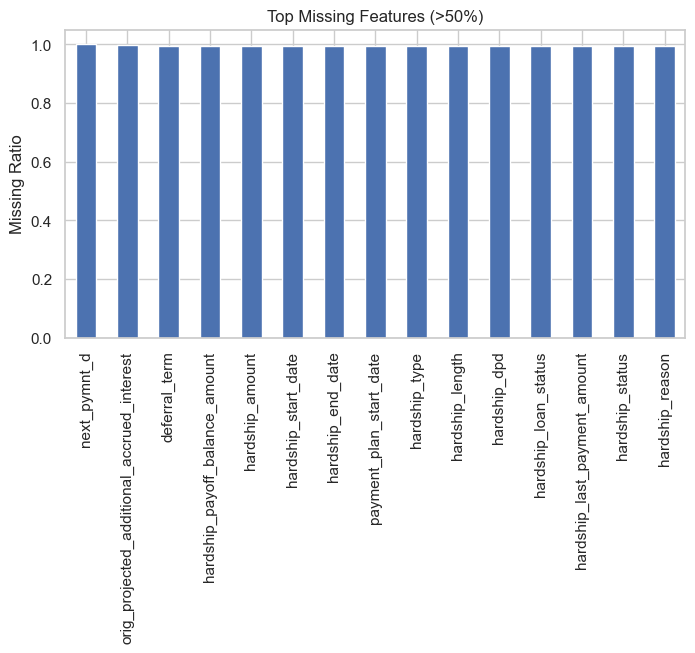

In [4]:
missing_ratio = df.isnull().mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
missing_ratio.head(15).plot(kind="bar")
plt.title("Top Missing Features (>50%)")
plt.ylabel("Missing Ratio")
plt.show()

In [5]:
df.drop(columns=missing_ratio[missing_ratio > 0.5].index, inplace=True)
print("After dropping high-missing cols:", df.shape)

After dropping high-missing cols: (1345310, 76)


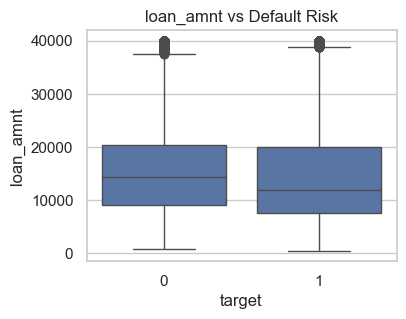

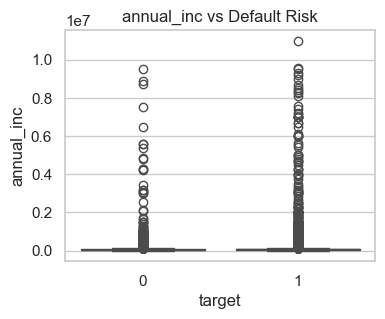

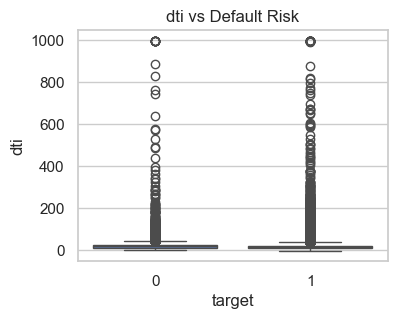

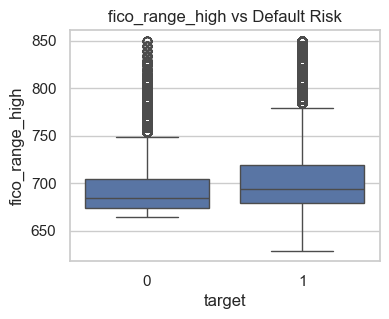

In [ ]:
features = ["loan_amnt", "annual_inc", "dti", "fico_range_high"] 

for col in features:
    plt.figure(figsize=(4,3))
    sns.boxplot(x="target", y=col, data=df)
    plt.title(f"{col} vs Default Risk")
    plt.show()

In [ ]:
df["annual_inc"] = np.log1p(df["annual_inc"]) #log1p untuk mengurangi nilai negatif, dan buat rentang nilai gitu
df["dti"] = df["dti"].clip(upper=100) 

In [ ]:
NUMERIC = df.select_dtypes(include=["int64","float64"]).columns
CATEGORICAL = df.select_dtypes(include=["object"]).columns

for col in NUMERIC:
    df[col] = df[col].fillna(df[col].median()) # pake median karena lebih robust terhadap outlier

for col in CATEGORICAL:
    df[col] = df[col].fillna(df[col].mode()[0]) # pake mode karena kategorikal

print("Remaining NaNs:", df.isnull().sum().sum())

Remaining NaNs: 0


In [ ]:
ORDINAL_MAP = {
    "term": {" 36 months": 36, " 60 months": 60},
    "grade": {"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7},
    "emp_length": {
        "< 1 year": 0,"1 year":1,"2 years":2,"3 years":3,"4 years":4,
        "5 years":5,"6 years":6,"7 years":7,"8 years":8,"9 years":9,"10+ years":10
    }
} # mapping ordinal features to numerical values

for col, mapping in ORDINAL_MAP.items(): # loop through ordinal features
    if col in df.columns:
        df[col] = df[col].map(mapping) 

LOW_CARD = ["home_ownership", "verification_status", "purpose"] 
df = pd.get_dummies(df, columns=[c for c in LOW_CARD if c in df.columns], drop_first=True) #drop_first=True untuk menghilangkan kolom pertama agar tidak terjadi dummy variable trap

In [ ]:
# === HANDLE HIGH-CARDINALITY CATEGORICAL FEATURES ===
# Alasan: terlalu banyak kategori, noise, fairness risk, tidak stabil untuk deployment

HIGH_CARD = [
    "addr_state",
    "emp_title",
    "sub_grade",
    "initial_list_status",
    "application_type",
    "disbursement_method",
    "pymnt_plan"
] #high card untuk kolom dengan banyak kategori
 
df.drop(columns=[c for c in HIGH_CARD if c in df.columns], inplace=True) #inplace adalah untuk menyimpan hasil operasi di df

print("Dropped high-cardinality / problematic categorical features (if existed).")

Dropped high-cardinality / problematic categorical features (if existed).


In [11]:
# === DROP DATE FEATURES ===
# Alasan:
# - issue_d: temporal leakage risk
# - earliest_cr_line: raw date, requires extra feature engineering

DATE_COLS = ["issue_d", "earliest_cr_line"]

df.drop(columns=[c for c in DATE_COLS if c in df.columns], inplace=True)

print("Dropped date-based features:", DATE_COLS)

Dropped date-based features: ['issue_d', 'earliest_cr_line']


In [ ]:
# === FINAL DATA TYPE AUDIT ===

object_cols = df.select_dtypes(include=["object"]).columns

print("Remaining object columns:", object_cols.tolist()) #tolist itu ubah objek jadi numerik

assert len(object_cols) == 0, \
    f"Non-numeric columns remain: {object_cols.tolist()}"

print("✅ Final dataset is fully numeric and safe for modeling.")

Remaining object columns: []
✅ Final dataset is fully numeric and safe for modeling.


In [13]:
df.to_csv("preprocessed_loan.csv", index=False)
print("Saved preprocessed_loan.csv")
print("Final shape:", df.shape)

Saved preprocessed_loan.csv
Final shape: (1345310, 84)
